In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [127]:
import numpy as np
import pandas as pd
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

In [49]:
# read data
data_location = "data/"
file_name = "orders_new.csv"
my_data = pd.read_csv(data_location + file_name)
my_data.head(5)

,country,date,experiment_id,order_id,spend_usd,user_id,vertical
0,US,2017-04-02,12624549,6720123150182430132,49.99,3659561261588336546,ANDROID_APPS
1,US,2017-04-01,12624549,17511438899767627798,0.99,3659561261588336546,ANDROID_APPS
2,US,2017-04-04,12624549,1549342062436664018,39.99,3659561261588336546,ANDROID_APPS
3,US,2017-04-04,12624549,7771425263197855716,19.99,3659561261588336546,ANDROID_APPS
4,US,2017-04-01,12624549,17943210556580942992,19.99,3659561261588336546,ANDROID_APPS


In [44]:
# columns type
my_data.dtypes

country           object
date              object
experiment_id      int64
order_id          object
spend_usd        float64
user_id           object
vertical          object
dtype: object

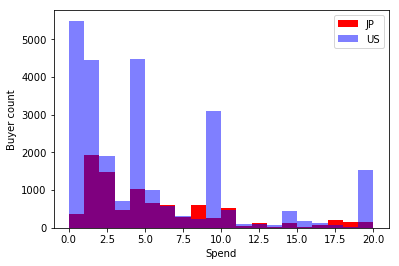

In [62]:
# distribution
#my_series = my_data[["spend_usd","country"]][(my_data.spend_usd < 20) & (my_data.country.isin(["US","JP","FR","UK"]))]
my_series_jp = my_data["spend_usd"][(my_data.spend_usd < 20) & (my_data.country == "JP")]
my_series_us = my_data["spend_usd"][(my_data.spend_usd < 20) & (my_data.country == "US")]

# play with it first
fig, ax = plt.subplots()
ax.hist(my_series_jp, bins=20,color='r',label='JP')
ax.hist(my_series_us, bins=20,color='b',label='US',alpha=0.5)
ax.legend()
ax.set_ylabel("Buyer count")
ax.set_xlabel("Spend")


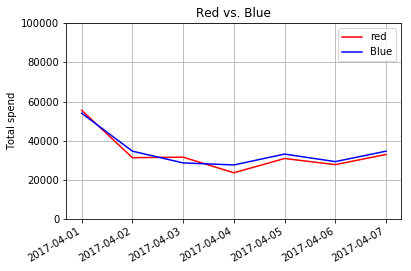

In [97]:
## x axis is messed up
my_data.date = pd.to_datetime(my_data.date, format='%Y-%m-%d')
# now plot both red and blue
red_button = np.unique(my_data["experiment_id"])[0]
blue_button = np.unique(my_data["experiment_id"])[1]

# subset the data
red_button_data = my_data[['date','spend_usd']][my_data.experiment_id == red_button]
blue_button_data = my_data[['date','spend_usd']][my_data.experiment_id == blue_button]

red_ts = red_button_data.groupby('date')['spend_usd'].sum()
blue_ts = blue_button_data.groupby('date')['spend_usd'].sum()

fig, ax = plt.subplots()
ax.plot(red_ts, color="red", label="red")
ax.plot(blue_ts, color="blue", label = "blue")

# some tweaks
ax.set_ylim(0,100000)
ax.set_title("Red vs. Blue")
ax.set_ylabel("Total spend")
ax.grid(True, which="both")
# change legend
ax.legend().get_texts()[0].set_text("Red")
ax.legend().get_texts()[1].set_text("Blue")
# format date
plt.gcf().autofmt_xdate()

In [183]:
# for any given experiment_id, return a list group by date
def GetSeries2(my_data, my_id,country, vertical):
    table = my_data[["date", "spend_usd"]][(my_data.experiment_id == my_id) & (my_data.country == country) & (my_data.vertical == vertical)  ]
    series = table.groupby('date')['spend_usd'].sum()
    return(series)

In [176]:
# for any given experiment_id, return a list group by date
def GetSeries(my_data, my_id):
    table = my_data[["date", "spend_usd"]][my_data.experiment_id == my_id]
    series = table.groupby('date')['spend_usd'].sum()
    return(series)

In [171]:
# for any two series, plot the time series
def PlotSeries(index_series, experiment_series, control_series):
    df = pd.DataFrame(
        {
            "experiment": experiment_series.tolist(),
            "control": control_series.tolist()
        },
        index = index_series.tolist(), # a range of dates
        columns = ["experiment", "control"]
    )
    print df.index
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(df)
    plt.legend(["Experiment","Control"])
    plt.gcf().autofmt_xdate()

In [219]:
# for any two series, plot the cumulative time series
def PlotCumulativeSeries(index_series, experiment_series, control_series):
    df = pd.DataFrame(
        {
            "experiment": np.cumsum(experiment_series).tolist(),
            "control": np.cumsum(control_series).tolist()
        },
        index = index_series.tolist(), # a range of dates
        columns = ["experiment", "control"]
    )
    result = []
    result.append(np.sum(np.cumsum(experiment_series).tolist()))
    result.append(np.sum(np.cumsum(control_series).tolist()))
#     print result
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(df)
    plt.legend(["Experiment","Control"])
    plt.gcf().autofmt_xdate()
    return result

In [220]:
def PrintDailyTimeSeries(my_data, experiment_ids):
    # make sure our x-axis is consistent
    date_series = pd.to_datetime(my_data.date, format='%Y-%m-%d')
    date_series = pd.DatetimeIndex(date_series).normalize()
    index_series = date_series.unique() # unique date
    index_series = index_series.sort_values(ascending=True) # sort by date
    
    # data grouping
    my_data = my_data.sort_values("date", ascending=True, inplace=False)
    treatment_series = GetSeries(my_data, experiment_ids[0])
    control_series = GetSeries(my_data, experiment_ids[1])
    PlotSeries(index_series, treatment_series, control_series)

In [221]:
def PrintDailyCumulativeTimeSeries(my_data, experiment_ids, country, vertical):
    # make sure our x-axis is consistent
    date_series = pd.to_datetime(my_data.date, format='%Y-%m-%d')
    date_series = pd.DatetimeIndex(date_series).normalize()
    index_series = date_series.unique() # unique date
    index_series = index_series.sort_values(ascending=True) # sort by date
    
    # data grouping
    my_data = my_data.sort_values("date", ascending=True, inplace=False)
    treatment_series = GetSeries2(my_data, experiment_ids[0], country, vertical)
    control_series = GetSeries2(my_data, experiment_ids[1],country, vertical)
    result = []
    result = PlotCumulativeSeries(index_series, treatment_series, control_series)
    uplift = (result[0]-result[1])/result[1] * 100
    print ' cumulative % uplift on revenue: ',"%.2f" % uplift, '%'

DatetimeIndex(['2017-04-01', '2017-04-02', '2017-04-03', '2017-04-04',
               '2017-04-05', '2017-04-06', '2017-04-07'],
              dtype='datetime64[ns]', freq=None)


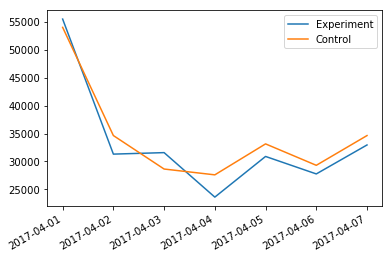

In [222]:
PrintDailyTimeSeries(my_data, [12624548,12624549])

 cumulative % uplift on revenue:  -4.36 %


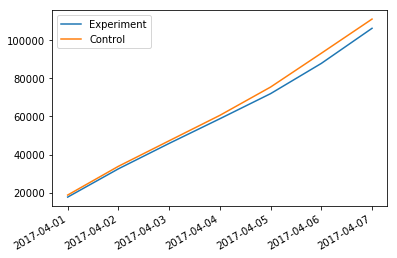

In [223]:
PrintDailyCumulativeTimeSeries(my_data, [12624548,12624549],'US','ANDROID_APPS')

In [6]:
s = pd.Series(np.random.randn(5), index=['a', 'b', 'c', 'd', 'e'])

In [8]:
s

a    0.584687
b    1.796479
c   -0.311480
d    1.919393
e   -0.686550
dtype: float64